# Capstone Project

In [850]:
# Primary Libraries
import urllib, json
import urllib3
import requests
import pandas as pd
from io import StringIO
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# settings to display all columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

# Clustering Libraries
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import calinski_harabasz_score, adjusted_rand_score
from clusteval import clusteval

# Linear Regression stuff
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols

import warnings
warnings.filterwarnings("ignore")

In [716]:
# Function for one-hot encoding
def one_h_e(df, categories, drop_first = True):
    '''Enter datframe and the columns you want to one hot encode'''
    
    df_ohe = df[categories].astype('category')
    
    df_ohe = pd.get_dummies(df_ohe, drop_first = drop_first)
    
    df_done = pd.concat([df, df_ohe], axis = 1)
    
    df_done = df_done.drop(categories, axis = 1)
    
    return df_done

In [802]:
clean_df = pd.read_csv('data/clean_df.csv')

In [803]:
model_df

,MarketCapitalization,EBITDA,PERatio,PEGRatio,BookValue,DividendYield,EPS,RevenuePerShareTTM,ProfitMargin,OperatingMarginTTM,ReturnOnAssetsTTM,ReturnOnEquityTTM,RevenueTTM,GrossProfitTTM,DilutedEPSTTM,QuarterlyEarningsGrowthYOY,QuarterlyRevenueGrowthYOY,PriceToSalesRatioTTM,PriceToBookRatio,EVToRevenue,EVToEBITDA,Beta,52WeekHigh,52WeekLow,SharesShort,SharesShortPriorMonth,ShortRatio,ShortPercentOutstanding,ShortPercentFloat,PercentInsiders,PercentInstitutions,PayoutRatio,split_ever,split_last_5_yrs,dividend_ever,dividend_3_yrs,ShortInterestMonthDelta,AnalystPercentTarget,PercentFloat,Country_USA,Sector_FINANCE,Sector_LIFE SCIENCES,Sector_MANUFACTURING,Sector_REAL ESTATE & CONSTRUCTION,Sector_TECHNOLOGY,Sector_TRADE & SERVICES,Market-Cap_Micro-Cap,Market-Cap_Mid-Cap,Market-Cap_Small-Cap
0,4.595638e+10,1.651000e+09,47.320000,2.420000,16.330000,0.0050,3.208,20.070,0.1610,0.2180,0.0835,0.200,6.142000e+09,2.837000e+09,3.208,0.344,0.258,7.480,9.370,7.780,30.09,1.042000,179.35,100.08,3431500.0,3890500.0,2.14,0.01,0.0114,0.266,90.25,0.189,1,0,1,1,-0.117980,0.047425,0.996888,1,0,1,0,0,0,0,0,0,0
1,9.137748e+09,1.730000e+09,21.230000,-0.290000,20.170000,0.0078,2.303,56.240,0.0412,0.1010,0.0476,0.105,1.046000e+10,1.362000e+09,2.303,1.163,0.319,0.874,2.432,0.930,5.73,2.576000,52.08,11.41,12203200.0,12320000.0,1.62,0.07,0.0658,0.963,79.03,0.000,1,0,1,0,-0.009481,0.169703,0.992792,1,0,0,1,0,0,0,0,1,0
2,1.221262e+09,0.000000e+00,100.720000,11.860072,0.040000,0.0000,0.097,0.000,0.0000,0.0000,0.0000,-99999.990,0.000000e+00,0.000000e+00,0.097,0.000,0.000,0.000,1.325,0.000,0.00,-3.505338,10.00,9.50,196150.0,90710.0,0.37,0.00,0.0010,0.000,58.70,0.000,0,0,0,0,1.162386,0.000000,0.722354,1,0,0,0,1,0,0,0,0,1
3,7.418100e+07,3.174873e+00,30.760262,-0.835078,6.860000,0.0000,-0.284,6.400,-0.2510,-0.4870,-0.0940,-0.194,1.774180e+08,5.774200e+07,-0.284,0.000,0.393,0.418,2.142,0.359,0.00,1.187000,7.50,1.06,38150.0,49190.0,0.65,0.00,0.0044,5.470,16.48,0.000,0,0,1,0,-0.224436,9.124611,0.276504,0,0,0,0,0,0,1,1,0,0
4,5.601320e+08,8.973977e-01,81.440220,1.394096,1.633035,0.0000,-0.358,1.809,-0.1300,-0.1530,0.0000,0.000,1.449960e+07,-4.283620e+05,-0.358,0.000,-1.000,38.630,0.000,0.000,0.00,3.540834,42.90,2.16,115090.0,116920.0,1.58,0.01,0.0087,1.725,14.53,0.000,0,0,0,0,-0.015652,4.603788,0.644909,1,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5248,4.366641e+09,4.199000e+08,20.590000,1.293000,13.090000,0.0093,1.751,16.740,0.1080,0.1640,0.0000,14.020,2.009100e+09,7.366660e+08,1.751,1.034,0.265,2.173,2.527,2.433,14.64,1.384000,65.68,30.31,2156000.0,1951300.0,3.25,0.02,0.0180,0.940,109.61,0.183,0,0,1,1,0.104904,0.000000,0.991199,1,0,0,0,0,1,0,0,1,0
5249,1.166222e+09,3.194716e-01,41.436100,14.051069,5.570000,0.0000,-11.170,0.644,0.0000,-16.2000,-0.5660,-1.977,1.873600e+07,-1.623860e+08,-11.170,0.000,3.841,62.240,2.469,48.460,0.00,-18.848545,52.00,9.51,4971500.0,4382200.0,4.58,0.04,0.0847,8.920,58.59,0.000,0,0,0,0,0.134476,0.350729,0.505313,1,0,0,0,0,0,1,0,0,1
5250,1.194576e+09,-5.161800e+07,64.809046,0.000000,6.950000,0.0000,-4.610,0.405,0.0000,-10.8500,-0.2610,-0.548,2.073800e+07,-1.295830e+08,-4.610,0.000,-0.857,57.600,4.066,47.220,0.00,1.022000,59.03,24.42,2854000.0,1732200.0,7.45,0.06,0.0685,0.834,76.64,0.000,0,0,0,0,0.647616,0.591229,0.895412,1,0,1,0,0,0,0,0,0,1
5251,1.666560e+08,-3.689572e+07,514.523676,0.000000,2.189000,0.0000,-1.082,0.004,0.0000,0.0000,-0.2500,-0.451,8.600000e+04,0.000000e+00,-1.082,0.000,0.000,1152.690,1.910,397.610,0.00,2.425000,9.00,3.15,1911700.0,1849600.0,0.79,0.05,0.0489,2.616,39.41,0.000,0,0,0,0,0.033575,0.777312,0.948227,1,0,1,0,0,0,0,1,0,0


In [804]:
model_df = clean_df.copy()

model_df.dropna(inplace=True)

model_stocks = model_df[['Symbol', 'Name', 'Description']]

model_df.drop(['Symbol', 'Name', 'Description', 'Unnamed: 0'], inplace=True, axis =1)

to_ohe = ['Country', 'Sector', 'Market-Cap']

model_df = one_h_e(model_df, to_ohe)

# Scale for subsequent iterations
scaler = StandardScaler()
model_df = pd.DataFrame(scaler.fit_transform(model_df), columns = model_df.columns)

In [805]:
model_df

,MarketCapitalization,EBITDA,PERatio,PEGRatio,BookValue,DividendYield,EPS,RevenuePerShareTTM,ProfitMargin,OperatingMarginTTM,ReturnOnAssetsTTM,ReturnOnEquityTTM,RevenueTTM,GrossProfitTTM,DilutedEPSTTM,QuarterlyEarningsGrowthYOY,QuarterlyRevenueGrowthYOY,PriceToSalesRatioTTM,PriceToBookRatio,EVToRevenue,EVToEBITDA,Beta,52WeekHigh,52WeekLow,ShortRatio,ShortPercentOutstanding,ShortPercentFloat,PercentInsiders,PercentInstitutions,PayoutRatio,split_ever,split_last_5_yrs,dividend_ever,dividend_3_yrs,ShortInterestMonthDelta,AnalystPercentTarget,PercentFloat,Country_USA,Sector_FINANCE,Sector_LIFE SCIENCES,Sector_MANUFACTURING,Sector_REAL ESTATE & CONSTRUCTION,Sector_TECHNOLOGY,Sector_TRADE & SERVICES,Market-Cap_Micro-Cap,Market-Cap_Mid-Cap,Market-Cap_Small-Cap
0,0.531958,-0.032500,-0.161613,-0.021655,-0.036676,-0.032361,-0.017018,-0.040821,0.064828,0.019316,0.247256,0.391744,-0.039721,-0.032173,-0.017010,-0.014523,-0.017922,-0.032536,-0.014223,-0.031123,-0.017731,-0.026283,0.006316,0.003425,-0.387740,-0.440159,-0.048874,-0.632126,-0.004282,0.214736,1.253985,-0.351961,1.083215,1.225328,-0.023141,-0.019849,1.024638,0.181765,-0.364478,2.052148,-0.362128,-0.487294,-0.468962,-0.360108,-0.660921,-0.506951,-0.737011
1,-0.017933,-0.032211,-0.255989,-0.055210,-0.036126,-0.027437,-0.017697,-0.033072,0.005309,0.019306,0.177555,0.391741,-0.036724,-0.033374,-0.017689,-0.014463,-0.017706,-0.032807,-0.015296,-0.031405,-0.074570,0.041657,-0.014411,-0.018152,-0.484232,1.203555,-0.004724,-0.593448,-0.007086,-0.266967,1.253985,-0.351961,1.083215,-0.816108,-0.022726,-0.019072,1.009348,0.181765,-0.364478,-0.487294,2.761452,-0.487294,-0.468962,-0.360108,-0.660921,1.972577,-0.737011
2,-0.136167,-0.038552,0.031551,0.095229,-0.039009,-0.041155,-0.019351,-0.045121,-0.015160,0.019298,0.085138,-2.552448,-0.043984,-0.034483,-0.019343,-0.014548,-0.018834,-0.032843,-0.015467,-0.031443,-0.087939,-0.377612,-0.021263,-0.018617,-0.716185,-0.714112,-0.057314,-0.646887,-0.012165,-0.266967,-0.797458,-0.351961,-0.923178,-0.816108,-0.018245,-0.020150,0.000000,0.181765,-0.364478,-0.487294,-0.362128,2.052148,-0.468962,-0.360108,-0.660921,-0.506951,1.356833
3,-0.153299,-0.038552,-0.221515,-0.061959,-0.038032,-0.041155,-0.019637,-0.043750,-0.139862,0.019257,-0.097367,0.391732,-0.043860,-0.034436,-0.019629,-0.014548,-0.017445,-0.032826,-0.015341,-0.031429,-0.087939,-0.019861,-0.021671,-0.020670,-0.664228,-0.714112,-0.054555,-0.343342,-0.022714,-0.266967,-0.797458,-0.351961,1.083215,-0.816108,-0.023548,0.037782,-1.664040,-5.501623,-0.364478,-0.487294,-0.362128,-0.487294,-0.468962,2.776948,1.513041,-0.506951,-0.737011
4,-0.146041,-0.038552,-0.038190,-0.034358,-0.038781,-0.041155,-0.019693,-0.044733,-0.079747,0.019285,0.085138,0.391738,-0.043973,-0.034484,-0.019685,-0.014548,-0.022369,-0.031258,-0.015672,-0.031443,-0.087939,2.165205,-0.015906,-0.020403,-0.491655,-0.440159,-0.051065,-0.551162,-0.023201,-0.266967,-0.797458,-0.351961,-0.923178,-0.816108,-0.022749,0.009080,-0.289048,0.181765,-0.364478,-0.487294,-0.362128,-0.487294,2.132367,-0.360108,-0.660921,-0.506951,1.356833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5248,-0.089191,-0.037013,-0.258304,-0.035609,-0.037140,-0.024799,-0.018111,-0.041534,0.038496,0.019312,0.085138,0.392151,-0.042589,-0.033884,-0.018103,-0.014473,-0.017897,-0.032754,-0.015281,-0.031343,-0.053780,-0.011136,-0.012196,-0.013553,-0.181765,-0.166207,-0.043517,-0.594724,0.000555,0.199444,-0.797458,-0.351961,1.083215,1.225328,-0.022288,-0.020150,1.003404,0.181765,-0.364478,-0.487294,-0.362128,-0.487294,2.132367,-0.360108,-0.660921,1.972577,-0.737011
5249,-0.136989,-0.038552,-0.182897,0.122358,-0.038217,-0.041155,-0.027802,-0.044983,-0.015160,0.017943,-1.013773,0.391680,-0.043971,-0.034616,-0.027794,-0.014548,-0.005256,-0.030289,-0.015290,-0.029446,-0.087939,0.012420,-0.014424,-0.018614,0.065033,0.381698,0.010615,-0

In [840]:
# Determining the number of clusters
k_means_3 = KMeans(n_clusters=3).fit(model_df)
k_means_4 = KMeans(n_clusters=4).fit(model_df)
k_means_5 = KMeans(n_clusters=5).fit(model_df)
k_means_6 = KMeans(n_clusters=6).fit(model_df)
k_means_7 = KMeans(n_clusters=7).fit(model_df)
k_means_8 = KMeans(n_clusters=8).fit(model_df)
k_means_9 = KMeans(n_clusters=9).fit(model_df)
k_means_10 = KMeans(n_clusters=10).fit(model_df)
k_means_11 = KMeans(n_clusters=11).fit(model_df)
k_means_12 = KMeans(n_clusters=12).fit(model_df)
k_means_13 = KMeans(n_clusters=13).fit(model_df)
k_means_14 = KMeans(n_clusters=14).fit(model_df)
k_means_15 = KMeans(n_clusters=15).fit(model_df)
k_means_16 = KMeans(n_clusters=16).fit(model_df)
k_means_17 = KMeans(n_clusters=17).fit(model_df)
k_means_18 = KMeans(n_clusters=18).fit(model_df)
k_means_19 = KMeans(n_clusters=19).fit(model_df)
k_means_20 = KMeans(n_clusters=20).fit(model_df)
k_means_21 = KMeans(n_clusters=21).fit(model_df)
k_means_22 = KMeans(n_clusters=22).fit(model_df)
k_means_23 = KMeans(n_clusters=23).fit(model_df)
k_means_24 = KMeans(n_clusters=24).fit(model_df)
k_means_25 = KMeans(n_clusters=25).fit(model_df)
k_means_26 = KMeans(n_clusters=26).fit(model_df)
k_means_27 = KMeans(n_clusters=27).fit(model_df)
k_means_28 = KMeans(n_clusters=28).fit(model_df)
k_means_29 = KMeans(n_clusters=29).fit(model_df)
k_means_30 = KMeans(n_clusters=30).fit(model_df)

k_list = [k_means_3, k_means_4,k_means_5, k_means_6, k_means_7, k_means_8, 
          k_means_9, k_means_10, k_means_11, k_means_12, k_means_13, k_means_14,
         k_means_15,k_means_16,k_means_17,k_means_18]

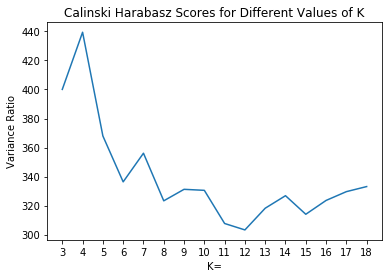

In [842]:
# Calculate Calinski-Harabasz score for different n of clusters
CH_score = []
for i in k_list:
    label = i.labels_
    CH_score.append(calinski_harabasz_score(model_df, label))

# Plot CH elbow graph
plt.plot(list(range(3,19)), CH_score)
plt.xticks(list(range(3,19)))
plt.title('Calinski Harabasz Scores for Different Values of K')
plt.ylabel('Variance Ratio')
plt.xlabel('K=')
plt.show()

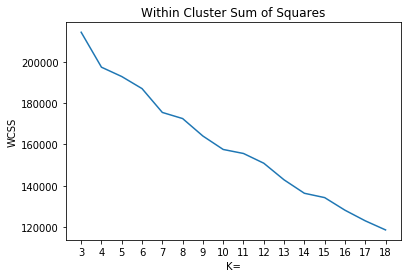

In [843]:
# Calculate the Within Cluster Sum of Squares for different n clusters
wcss_score = []
for i in k_list:
    wcss_score.append(i.inertia_)

# Plot WCSS elbow graph
plt.plot(list(range(3,19)), wcss_score)
plt.xticks(list(range(3,19)))
plt.title('Within Cluster Sum of Squares')
plt.ylabel('WCSS')
plt.xlabel('K=')
plt.show()

In [844]:
cluster7_preds = k_means_7.predict(model_df)

In [845]:
testtest = model_df.copy()

In [846]:
testtest['preds'] = cluster7_preds

In [847]:
testtest['preds'].value_counts()

0    2131
1    1752
4     786
3     578
6       3
2       2
5       1
Name: preds, dtype: int64

In [832]:
testtest[['Symbol', 'Name']] = model_stocks[['Symbol', 'Name']]

In [833]:
testtest

,MarketCapitalization,EBITDA,PERatio,PEGRatio,BookValue,DividendYield,EPS,RevenuePerShareTTM,ProfitMargin,OperatingMarginTTM,ReturnOnAssetsTTM,ReturnOnEquityTTM,RevenueTTM,GrossProfitTTM,DilutedEPSTTM,QuarterlyEarningsGrowthYOY,QuarterlyRevenueGrowthYOY,PriceToSalesRatioTTM,PriceToBookRatio,EVToRevenue,EVToEBITDA,Beta,52WeekHigh,52WeekLow,ShortRatio,ShortPercentOutstanding,ShortPercentFloat,PercentInsiders,PercentInstitutions,PayoutRatio,split_ever,split_last_5_yrs,dividend_ever,dividend_3_yrs,ShortInterestMonthDelta,AnalystPercentTarget,PercentFloat,Country_USA,Sector_FINANCE,Sector_LIFE SCIENCES,Sector_MANUFACTURING,Sector_REAL ESTATE & CONSTRUCTION,Sector_TECHNOLOGY,Sector_TRADE & SERVICES,Market-Cap_Micro-Cap,Market-Cap_Mid-Cap,Market-Cap_Small-Cap,preds,Symbol,Name
0,0.531958,-0.032500,-0.161613,-0.021655,-0.036676,-0.032361,-0.017018,-0.040821,0.064828,0.019316,0.247256,0.391744,-0.039721,-0.032173,-0.017010,-0.014523,-0.017922,-0.032536,-0.014223,-0.031123,-0.017731,-0.026283,0.006316,0.003425,-0.387740,-0.440159,-0.048874,-0.632126,-0.004282,0.214736,1.253985,-0.351961,1.083215,1.225328,-0.023141,-0.019849,1.024638,0.181765,-0.364478,2.052148,-0.362128,-0.487294,-0.468962,-0.360108,-0.660921,-0.506951,-0.737011,3,A,Agilent Technologies Inc
1,-0.017933,-0.032211,-0.255989,-0.055210,-0.036126,-0.027437,-0.017697,-0.033072,0.005309,0.019306,0.177555,0.391741,-0.036724,-0.033374,-0.017689,-0.014463,-0.017706,-0.032807,-0.015296,-0.031405,-0.074570,0.041657,-0.014411,-0.018152,-0.484232,1.203555,-0.004724,-0.593448,-0.007086,-0.266967,1.253985,-0.351961,1.083215,-0.816108,-0.022726,-0.019072,1.009348,0.181765,-0.364478,-0.487294,2.761452,-0.487294,-0.468962,-0.360108,-0.660921,1.972577,-0.737011,0,AA,Alcoa Corporation
2,-0.136167,-0.038552,0.031551,0.095229,-0.039009,-0.041155,-0.019351,-0.045121,-0.015160,0.019298,0.085138,-2.552448,-0.043984,-0.034483,-0.019343,-0.014548,-0.018834,-0.032843,-0.015467,-0.031443,-0.087939,-0.377612,-0.021263,-0.018617,-0.716185,-0.714112,-0.057314,-0.646887,-0.012165,-0.266967,-0.797458,-0.351961,-0.923178,-0.816108,-0.018245,-0.020150,0.000000,0.181765,-0.364478,-0.487294,-0.362128,2.052148,-0.468962,-0.360108,-0.660921,-0.506951,1.356833,1,AAC,Ares Acquisition Corporation
3,-0.153299,-0.038552,-0.221515,-0.061959,-0.038032,-0.041155,-0.019637,-0.043750,-0.139862,0.019257,-0.097367,0.391732,-0.043860,-0.034436,-0.019629,-0.014548,-0.017445,-0.032826,-0.015341,-0.031429,-0.087939,-0.019861,-0.021671,-0.020670,-0.664228,-0.714112,-0.054555,-0.343342,-0.022714,-0.266967,-0.797458,-0.351961,1.083215,-0.816108,-0.023548,0.037782,-1.664040,-5.501623,-0.364478,-0.487294,-0.362128,-0.487294,-0.468962,2.776948,1.513041,-0.506951,-0.737011,16,AACG,ATA Creativity Global
4,-0.146041,-0.038552,-0.038190,-0.034358,-0.038781,-0.041155,-0.019693,-0.044733,-0.079747,0.019285,0.085138,0.391738,-0.043973,-0.034484,-0.019685,-0.014548,-0.022369,-0.031258,-0.015672,-0.031443,-0.087939,2.165205,-0.015906,-0.020403,-0.491655,-0.440159,-0.051065,-0.551162,-0.023201,-0.266967,-0.797458,-0.351961,-0.923178,-0.816108,-0.022749,0.009080,-0.289048,0.181765,-0.364478,-0.487294,-0.362128,-0.487294,2.132367,-0.360108,-0.660921,-0.506951,1.356833,2,AADI,Aadi Bioscience Inc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5248,-0.089191,-0.037013,-0.258304,-0.035609,-0.037140,-0.024799,-0.018111,-0.041534,0.038496,0.019312,0.085138,0.392151,-0.042589,-0.033884,-0.018103,-0.014473,-0.017897,-0.032754,-0.015281,-0.031343,-0.053780,-0.011136,-0.012196,-0.013553,-0.181765,-0.166207,-0.043517,-0.594724,0.000555,0.199444,-0.797458,-0.351961,1.083215,1.225328,-0.022288,-0.020150,1.003404,0.181765,-0.364478,-0.487294,-0.362128,-0.487294,2.132367,-0.360108,-0.660921,1.972577,-0.737011,76,ZWS,Zurn Water Solutions Corporation
5249,-0.136989,-0.038552,-0.182897,0.122358,-0.038217,-0

In [836]:
testtest[testtest['preds']== 1]

,MarketCapitalization,EBITDA,PERatio,PEGRatio,BookValue,DividendYield,EPS,RevenuePerShareTTM,ProfitMargin,OperatingMarginTTM,ReturnOnAssetsTTM,ReturnOnEquityTTM,RevenueTTM,GrossProfitTTM,DilutedEPSTTM,QuarterlyEarningsGrowthYOY,QuarterlyRevenueGrowthYOY,PriceToSalesRatioTTM,PriceToBookRatio,EVToRevenue,EVToEBITDA,Beta,52WeekHigh,52WeekLow,ShortRatio,ShortPercentOutstanding,ShortPercentFloat,PercentInsiders,PercentInstitutions,PayoutRatio,split_ever,split_last_5_yrs,dividend_ever,dividend_3_yrs,ShortInterestMonthDelta,AnalystPercentTarget,PercentFloat,Country_USA,Sector_FINANCE,Sector_LIFE SCIENCES,Sector_MANUFACTURING,Sector_REAL ESTATE & CONSTRUCTION,Sector_TECHNOLOGY,Sector_TRADE & SERVICES,Market-Cap_Micro-Cap,Market-Cap_Mid-Cap,Market-Cap_Small-Cap,preds,Symbol,Name
2,-0.136167,-0.038552,0.031551,0.095229,-0.039009,-0.041155,-0.019351,-0.045121,-0.01516,0.019298,0.085138,-2.552448,-0.043984,-0.034483,-0.019343,-0.014548,-0.018834,-0.032843,-0.015467,-0.031443,-0.087939,-0.377612,-0.021263,-0.018617,-0.716185,-0.714112,-0.057314,-0.646887,-0.012165,-0.266967,-0.797458,-0.351961,-0.923178,-0.816108,-0.018245,-0.02015,0.000000,0.181765,-0.364478,-0.487294,-0.362128,2.052148,-0.468962,-0.360108,-0.660921,-0.506951,1.356833,1,AAC,Ares Acquisition Corporation
45,-0.148130,-0.038552,-0.211939,0.095229,-0.038998,-0.041155,-0.019424,-0.045121,-0.01516,0.019298,0.085138,-2.552448,-0.043984,-0.034483,-0.019416,-0.014548,-0.018834,-0.032843,-0.015672,-0.031443,-0.087939,-0.354639,-0.021265,-0.018590,-0.753298,-0.714112,-0.057964,-0.646887,-0.013309,-0.266967,-0.797458,-0.351961,-0.923178,-0.816108,-0.021974,-0.02015,0.877019,0.181765,-0.364478,-0.487294,-0.362128,2.052148,-0.468962,-0.360108,-0.660921,-0.506951,1.356833,1,ACAH,Atlantic Coastal Acquisition Corp
80,-0.145346,-0.038552,-0.211939,0.095229,-0.039003,-0.041155,-0.019424,-0.045121,-0.01516,0.019298,0.085138,-2.552448,-0.043984,-0.034483,-0.019416,-0.014548,-0.018834,-0.032843,-0.015672,-0.031443,-0.087939,-0.332931,-0.021236,-0.018585,-0.784844,-0.714112,-0.058126,-0.646887,-0.006269,-0.266967,-0.797458,-0.351961,-0.923178,-0.816108,0.067002,-0.02015,1.012785,0.181765,-0.364478,-0.487294,-0.362128,2.052148,-0.468962,-0.360108,-0.660921,-0.506951,1.356833,1,ACQR,Independence Holdings Corp
81,-0.145204,-0.038552,-0.211939,0.095229,-0.039003,-0.041155,-0.019424,-0.045121,-0.01516,0.019298,0.085138,-2.552448,-0.043984,-0.034483,-0.019416,-0.014548,-0.018834,-0.032843,-0.015672,-0.031443,-0.087939,-0.191991,-0.021184,-0.018539,-0.268980,-0.714112,-0.057801,-0.646887,-0.001567,-0.266967,-0.797458,-0.351961,-0.923178,-0.816108,-0.025928,-0.02015,0.000000,0.181765,-0.364478,-0.487294,-0.362128,2.052148,-0.468962,-0.360108,-0.660921,-0.506951,1.356833,1,ACQRU,Independence Holdings Corp
90,-0.149325,-0.038552,-0.211939,0.095229,-0.038996,-0.041155,-0.019424,-0.045121,-0.01516,0.019298,0.085138,-2.552448,-0.043984,-0.034483,-0.019416,-0.014548,-0.018834,-0.032843,-0.015672,-0.031443,-0.087939,-1.282352,-0.021200,-0.018561,-0.126096,-0.714112,-0.058126,-0.646887,-0.015720,-0.266967,-0.797458,-0.351961,-0.923178,-0.816108,-0.026513,-0.02015,0.000000,0.181765,-0.364478,-0.487294,-0.362128,2.052148,-0.468962,-0.360108,-0.660921,-0.506951,1.356833,1,ACTDU,ArcLight Clean Transition Corp. II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4708,-0.148299,-0.038552,-0.211939,0.095229,-0.038997,-0.041155,-0.019435,-0.045121,-0.01516,0.019298,0.085138,-2.552448,-0.043984,-0.034483,-0.019427,-0.014548,-0.018834,-0.032843,-0.015672,-0.031443,-0.087939,-0.519710,-0.020995,-0.018697,-0.690207,-0.440159,-0.051714,-0.441509,-0.003928,-0.266967,-0.797458,-0.351961,-0.923178,-0.816108,-0.026221,-0.02015,0.266045,0.181765,-0.364478,-0.487294,-0.362128,2.052148,-0.468962,-0.360108,-0.660921,-0.506951,1.356833,1,TWND,Tailwind Acquisition Corp
4709,-0.148

In [104]:
testtest[testtest['preds']== 4]

,MarketCapitalization,EBITDA,PERatio,PEGRatio,BookValue,DividendPerShare,DividendYield,EPS,RevenuePerShareTTM,ProfitMargin,OperatingMarginTTM,ReturnOnAssetsTTM,ReturnOnEquityTTM,RevenueTTM,GrossProfitTTM,DilutedEPSTTM,QuarterlyEarningsGrowthYOY,QuarterlyRevenueGrowthYOY,AnalystTargetPrice,TrailingPE,ForwardPE,PriceToSalesRatioTTM,PriceToBookRatio,EVToRevenue,EVToEBITDA,Beta,52WeekHigh,52WeekLow,50DayMovingAverage,200DayMovingAverage,SharesOutstanding,SharesFloat,SharesShort,SharesShortPriorMonth,ShortRatio,ShortPercentOutstanding,ShortPercentFloat,PercentInsiders,PercentInstitutions,ForwardAnnualDividendRate,ForwardAnnualDividendYield,PayoutRatio,preds,Symbol,Name
1,-0.283513,-0.080738,-0.128404,-0.056784,-0.064868,-0.051204,-0.299704,-0.115980,-0.060804,-0.474084,-0.408377,-0.215306,0.122682,-0.079862,-0.087148,-0.115980,-0.066307,-0.078445,-0.322560,-0.128404,-0.179809,-0.534275,-0.171389,-0.625968,-0.689373,2.327673,-0.271688,-0.423710,-0.251803,-0.303669,-0.216059,-0.198668,0.734468,0.758395,-0.793784,1.475227,0.985604,-0.502512,0.277547,-0.888766,-0.659693,-0.425632,4,AA,Alcoa Corporation
31,-0.378449,-0.082435,-0.162571,0.239951,-0.067174,-0.051272,-0.236517,-0.151667,-0.064885,-0.386356,-0.349903,0.477962,0.122693,-0.081694,-0.087503,-0.151667,-0.079801,-0.023796,-0.437201,-0.162571,-0.158240,-0.531383,-0.126106,-0.590822,-0.668769,0.556050,-0.349510,-0.409396,-0.371490,-0.347000,-0.236808,-0.278136,2.008040,1.754376,-0.099185,4.073910,4.171880,-0.148807,1.468225,-0.449963,0.045408,0.011888,4,NaN,NaN
35,-0.399024,-0.083233,-0.056848,-0.054553,-0.067556,-0.051773,-0.389430,-0.200791,-0.068403,0.077724,0.074031,-0.328392,0.122680,-0.082951,-0.089165,-0.200791,-0.054418,5.056875,-0.606480,-0.056848,-0.025616,0.503893,-0.195634,0.248772,0.087316,-0.429617,-0.432548,-0.439429,-0.467338,-0.462868,-0.136994,-0.149422,1.235841,1.444086,-0.034631,1.475227,1.330875,0.380211,-1.224450,-0.876577,-0.608458,-0.383134,4,NaN,NaN
45,-0.431785,-0.083443,-0.142030,-0.036037,-0.063405,-0.051665,-0.370474,-0.140978,-0.061866,-0.496016,-0.875680,-0.939714,0.122680,-0.082576,-0.089013,-0.140978,0.028820,-0.383153,-0.353941,-0.142030,-0.086937,-0.572282,-0.238579,-0.656623,-0.343581,1.013451,-0.309453,-0.363908,-0.338558,-0.317278,-0.388005,-0.434218,-0.290688,-0.331254,1.610200,1.150391,1.039978,-0.276653,0.768265,-0.705931,-0.488908,-0.425632,4,NaN,NaN
56,-0.388881,-0.083395,0.228099,-0.165905,-0.056712,-0.051786,-0.398277,-0.103241,-0.058391,-0.494261,-1.162201,-1.180637,0.122677,-0.082734,-0.089205,-0.103241,-0.059874,3.604545,1.250518,0.228099,-0.133997,-0.115166,-0.132249,-0.132365,0.096275,0.920038,0.984534,0.523460,0.656848,0.783441,-0.407797,-0.463003,-0.435935,-0.461422,0.332035,0.825556,0.770830,0.371757,0.602431,0.817690,0.255231,-0.425632,4,ACC,American Campus Communities Inc
77,-0.358428,-0.081727,-0.231710,-0.054553,-0.022511,-0.046487,-0.179648,1.204047,-0.045331,0.204930,0.259198,-0.629956,0.122685,-0.081720,-0.087659,1.204047,-0.075984,-0.573595,-0.085301,-0.231710,-0.327763,-0.478298,-0.262389,-0.595703,-1.202687,-0.494040,0.547684,0.052948,0.630121,0.443025,-0.397754,-0.484069,-0.497978,-0.505632,-0.538150,-0.473786,4.797173,0.860917,0.823882,1.110225,-0.237608,-0.307038,4,NaN,NaN
79,-0.412787,-0.082764,-0.213183,-0.243244,-0.065627,-0.051786,-0.398277,-0.027766,-0.060606,-0.318806,-0.476109,0.010867,0.122699,-0.081993,-0.086246,-0.027766,0.087597,-0.212583,-0.345518,-0.213183,-0.165192,-0.588187,-0.172041,-0.660137,-0.723415,1.023114,-0.299138,-0.400614,-0.310971,-0.305017,-0.361188,-0.396058,0.206744,0.034479,-0.419371,3.099404,2.513494,-0.453294,0.985985,-0.401207,1.023767,-0.425632,4,NaN,NaN
90,-0.348249,-0.082748,-0.060003,-0.065018,-0.058910,-0.049969,-0.245363,-0.087011,-0.063192,-0.323192,-0.442487,-0.659456,0.122678,-0.082363,-0.088234,-0.087011,-0.066370,-0.424553,0.041118,-0.060003,-0.049146,-0.226502,-0.210094,-0.231554,0.068504,0.206557,-0.022117,0.066735,0.014482,0.014600,-0.359314,-0.398671,0.076701,-0.318785

In [105]:
testtest[testtest['preds']== 1]

,MarketCapitalization,EBITDA,PERatio,PEGRatio,BookValue,DividendPerShare,DividendYield,EPS,RevenuePerShareTTM,ProfitMargin,OperatingMarginTTM,ReturnOnAssetsTTM,ReturnOnEquityTTM,RevenueTTM,GrossProfitTTM,DilutedEPSTTM,QuarterlyEarningsGrowthYOY,QuarterlyRevenueGrowthYOY,AnalystTargetPrice,TrailingPE,ForwardPE,PriceToSalesRatioTTM,PriceToBookRatio,EVToRevenue,EVToEBITDA,Beta,52WeekHigh,52WeekLow,50DayMovingAverage,200DayMovingAverage,SharesOutstanding,SharesFloat,SharesShort,SharesShortPriorMonth,ShortRatio,ShortPercentOutstanding,ShortPercentFloat,PercentInsiders,PercentInstitutions,ForwardAnnualDividendRate,ForwardAnnualDividendYield,PayoutRatio,preds,Symbol,Name
2,-0.436918,-0.082210,-0.210163,-0.044164,-0.064503,-0.051463,-0.307287,-0.083347,-0.061181,-0.402147,-0.276811,0.237039,-8.107101,-0.082541,-0.087610,-0.083347,-0.072794,-0.465954,-0.462544,-0.210163,-0.146653,-0.612355,-0.235970,-0.686692,-1.062757,1.396766,-0.356731,-0.383139,-0.374501,-0.367092,-0.391183,-0.436025,-0.451253,-0.458104,-0.460686,-0.148951,-0.205171,-0.431614,0.807943,-0.644986,-0.310802,-0.348534,1,NaN,NaN
3,-0.386588,-0.083326,0.051962,-0.032467,-0.067220,-0.051172,-0.328771,-0.154066,-0.067338,-0.001231,-0.047789,0.971281,0.122691,-0.082947,-0.089148,-0.154066,-0.075671,-0.364937,-0.271947,0.051962,-0.327763,0.741436,0.200332,0.508460,1.414049,-0.924061,-0.105842,-0.032583,-0.130887,-0.133943,-0.368774,-0.421839,-0.371124,-0.373809,1.638604,0.175885,0.172724,0.695448,0.026592,-0.657175,-0.525505,-0.087150,1,NaN,NaN
5,-0.410023,-0.083212,0.591449,0.113592,-0.064772,-0.050074,-0.048218,-0.203278,-0.067917,-0.420131,0.293308,-0.705347,0.122675,-0.083000,-0.089032,-0.203278,-0.075267,-0.412961,-0.437425,0.591449,-0.327763,0.714584,-0.204223,1.242617,0.500297,0.204946,-0.337361,-0.347487,-0.304028,-0.321194,-0.359610,-0.404696,-0.396000,-0.414455,0.282974,-0.148951,-0.158954,-0.479685,1.047367,-0.157428,0.106403,0.374190,1,NaN,NaN
6,0.781260,-0.077702,-0.190294,-0.052452,-0.067287,-0.050326,-0.054537,-0.096348,-0.066786,0.235634,-0.421046,-0.339865,0.122679,-0.074389,-0.076126,-0.096348,-0.063745,-0.258951,-0.445475,-0.190294,0.024474,-0.227741,-0.045597,-0.321371,0.915068,-0.084956,-0.352204,-0.318420,-0.322644,-0.334482,1.850017,2.043080,-0.299540,-0.265219,-0.651765,-0.798621,-0.767935,-0.560668,-2.201817,-0.358546,-0.013147,-0.023214,1,NaN,NaN
9,-0.395259,-0.082765,-0.124309,-0.020308,-0.064258,-0.050566,-0.192286,-0.123222,-0.056120,-0.549091,-0.594031,0.028895,0.122681,-0.081240,-0.087916,-0.123222,-0.061738,-0.429521,-0.271947,-0.124309,-0.327763,-0.606984,-0.193949,-0.694307,-0.208309,0.443310,-0.255986,-0.234645,-0.254629,-0.247051,-0.351923,-0.388060,-0.375313,-0.353779,-0.362564,-0.148951,-0.180703,-0.487717,0.806586,-0.425585,-0.259567,-0.147324,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,-0.384905,-0.082177,-0.173042,-0.051598,-0.063248,-0.050171,0.202004,-0.154503,-0.063607,-0.473645,-0.541892,-0.610288,0.122678,-0.080873,-0.085053,-0.154503,-0.048217,-0.235767,-0.586503,-0.173042,-0.155566,-0.608843,-0.264890,-0.642369,-0.547831,1.055326,-0.420628,-0.380593,-0.410259,-0.406828,-0.225576,-0.272929,-0.524608,0.173637,-0.096602,0.825556,0.800735,-0.224898,0.465424,-0.279317,0.499210,0.290196,1,NaN,NaN
995,-0.055065,-0.082111,0.105192,-0.035453,-0.065470,-0.050041,-0.285803,-0.123964,-0.064655,-0.330210,-0.315794,-0.251362,0.122684,-0.081493,-0.086362,-0.123964,-0.053011,-0.333472,0.172829,0.105192,0.352647,0.135391,0.091066,0.069529,1.432861,-0.110725,0.225162,0.207502,0.265530,0.219119,-0.223672,-0.208220,-0.164710,-0.136065,0.047998,-0.148951,-0.275856,-0.497681,0.706883,-0.206184,-0.435232,0.094628,1,NaN,NaN
997,0.010330,-0.081013,-0.102359,-0.038562,-0.065700,-0.051204,-0.321188,-0.113624,-0.065431,-0.198619,-0.359649,0.205900,0.122690,-0.080124,-0.086697,-0.113624,-0.074622,-0.128126

# Finding All stocks on NYSE and NASDAQ

In [42]:
NYSE = pd.read_csv('data/NYSE_LIST_OF_SYMBOLS.csv')
NASDAQ = pd.read_csv('data/NASDAQ_LIST_OF_SYMBOLS.csv')

stock_list = pd.concat([NYSE, NASDAQ])

In [43]:
stock_list.head()

,Code,Name,Country,Exchange,Currency,Type,Isin
0,A,Agilent Technologies Inc,USA,NYSE,USD,Common Stock,US00846U1016
1,AA,Alcoa Corporation,USA,NYSE,USD,Common Stock,US0138721065
2,AAA,Listed Funds Trust - AAF First Priority CLO Bo...,USA,NYSE ARCA,USD,ETF,NaN
3,AAAU,Goldman Sachs Physical Gold ETF,USA,NYSE ARCA,USD,ETF,US7154261025
4,AAC,Ares Acquisition Corporation,USA,NYSE,USD,Common Stock,KYG330321061


In [44]:
stock_list.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11005 entries, 0 to 5263
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Code      11005 non-null  object
 1   Name      11003 non-null  object
 2   Country   11003 non-null  object
 3   Exchange  11003 non-null  object
 4   Currency  11003 non-null  object
 5   Type      11003 non-null  object
 6   Isin      8539 non-null   object
dtypes: object(7)
memory usage: 687.8+ KB


In [45]:
stock_list.Type.value_counts()

Common Stock       8029
ETF                2171
FUND                442
Preferred Share     328
Mutual Fund          22
Fund                  8
Preferred Stock       2
BOND                  1
Name: Type, dtype: int64

In [46]:
stocks = stock_list[stock_list['Type'] == 'Common Stock'].sort_values(by='Code')
stocks.shape

(8029, 7)

In [47]:
stocks.to_csv('data/stock_tickers')

# Downloading Stock Info


In [ ]:
key_alpha_old = 'C9TOSUV8PMESV234'
key_alpha = 'YTEP4AMCUANDLBKB'
key_EOD = '6164aa3912fe92.68825657'

In [ ]:
# base_data = pd.DataFrame(columns = ['Symbol', 'AssetType', 'Name', 'Description', 'CIK', 'Exchange', 
#                                     'Currency', 'Country', 'Sector', 'Industry', 'Address', 'FiscalYearEnd', 
#                                     'LatestQuarter', 'MarketCapitalization', 'EBITDA', 'PERatio', 'PEGRatio', 
#                                     'BookValue', 'DividendPerShare', 'DividendYield', 'EPS', 'RevenuePerShareTTM', 
#                                     'ProfitMargin', 'OperatingMarginTTM', 'ReturnOnAssetsTTM', 'ReturnOnEquityTTM', 
#                                     'RevenueTTM', 'GrossProfitTTM', 'DilutedEPSTTM', 'QuarterlyEarningsGrowthYOY', 
#                                     'QuarterlyRevenueGrowthYOY', 'AnalystTargetPrice', 'TrailingPE', 'ForwardPE', 
#                                     'PriceToSalesRatioTTM', 'PriceToBookRatio', 'EVToRevenue', 'EVToEBITDA', 'Beta', 
#                                     '52WeekHigh', '52WeekLow', '50DayMovingAverage', '200DayMovingAverage', 
#                                     'SharesOutstanding', 'SharesFloat', 'SharesShort', 'SharesShortPriorMonth', 
#                                     'ShortRatio', 'ShortPercentOutstanding', 'ShortPercentFloat', 'PercentInsiders', 
#                                     'PercentInstitutions', 'ForwardAnnualDividendRate', 'ForwardAnnualDividendYield', 
#                                     'PayoutRatio', 'DividendDate', 'ExDividendDate', 'LastSplitFactor', 'LastSplitDate'])


In [ ]:
# %%time
# for i in stocks.Code.values[160:]:
#     url = f'https://www.alphavantage.co/query?function=OVERVIEW&symbol={i}&apikey={key_alpha}'
#     r = requests.get(url)
#     data_overview = r.json()
    
#     if data_overview == {}:
#         continue
#     else:
#         base_data = base_data.append(data_overview, ignore_index = True)

In [ ]:
# base_data.to_csv('data/base_data.csv')

# Cleaning Base Stock info

In [159]:
base_1 = pd.read_csv('data/base_data.csv')

In [169]:
base_1['state'] = base_1['Address'].map(lambda x: str(x)[-6:])

In [177]:
base_1['Industry'].value_counts()

BLANK CHECKS                                   975
GENERAL                                        683
PHARMACEUTICAL PREPARATIONS                    455
REAL ESTATE INVESTMENT TRUSTS                  196
STATE COMMERCIAL BANKS                         188
                                              ... 
STRUCTURAL CLAY PRODUCTS                         1
CUT STONE & STONE PRODUCTS                       1
PUBLIC BLDG & RELATED FURNITURE                  1
SERVICES-NURSING & PERSONAL CARE FACILITIES      1
ELECTRIC, GAS & SANITARY SERVICES                1
Name: Industry, Length: 375, dtype: int64

**Justification for dropping columns:**

1. **AssetType** - Since we are only looking at Common Stock Assets we can drop the column
2. **Currency** - All Currencies were USD
3. **Address** - The Headquarters of a company may have some bearing what kind of company it is (think Silicon Valley) but we want to focus more on stock features and performance.
4. **CIK** - Central Index key, is just a unique id for each stock. 
5. **FiscalYearEnd** - The month in which the company registers its year end. I don't think it's a relevant feature for seperating stocks.
6. **LatestQuarter** - 
7. **Industry** - The industry segment was split into too many niche categories (375) and the majority of stocks were saved as "Blank Checks" or "General"
8. **Exchange** - After reading a bit about the difference between the NASDAQ and NYSE and breaking down the .describe of each exchange the key differences seem to be that the biggest stocks (Apple, Microsoft, Alphabet, Amazon, Facebook) are all on the NASDAQ, but also a lot of the smallest stocks are on NASDAQ. May return this column in subsequent iterations, but for now, we are dropping it. 
9. **LastSplitDate** - Turned into two boolean columns: one if the stock has ever split, and two if the stock has split in the last five years. This hopes to seperate out stocks that grew in price far enough that it made sense to split the stock to keep the individual share price at a reasonable amount.
10. **LastSplitFactor** - Removed in favour of Last Split Date. There may be some favour in adding it for showing how high the ratio of a stock split was, but because adding it may skew the data in favour of stocks that have had splits, it was removed. 
11. **Dividend Date** - 
12. **ExDividendDate** - 
13. **DividendPerShare** - Too many null values to try and salvage
14. **TrailingPE** - Price-to-earnings for the actual earnings from the last 12 months. A lot of values are 0 and we already have PERatio as a column
15. **ForwardPE** - Price-to-earnings for the forecasted earnings. Would have been a cool metric but more than 3000 rows have no data for ForwardPE.


**Justification for filling null variables:**

1. **Beta** - Because Beta is a pretty important feature and a lot of cool stocks did not have beta data we filled the remaining null values with normally distributed datapoints with the same mean and std. 

In [665]:
def Pearson_Corr_matrix(cleaned_df):
    '''Use this function to print out a Pearson Correlation Matrix for a cleaned dataframe.
    The dataframe should not have any null values'''
    features = [i for i in cleaned_df.columns]

    mask = np.zeros_like(cleaned_df[features].corr(), dtype=np.bool) 
    mask[np.triu_indices_from(mask)] = True 

    f, ax = plt.subplots(figsize=(16, 12))
    plt.title('Pearson Correlation Matrix',fontsize=25)

    sns.heatmap(cleaned_df[features].corr(),annot=True, cmap='BuGn', 
                linecolor="w", mask = mask)
    
def print_regplot(cleaned_df, x, y):
    '''Print a regplot for a cleaned dataframe.
    Inputs:
    cleaned_df - try to remove empty rows
    x - the x value you are using to predict y - for selecting x value run Pearson_Corr_matrix
    y - the output value you are trying to fill null values for
    '''
    # Plot using table above
    plt.figure(figsize =(10,6))
    sns.regplot(data= cleaned_df, x= x, y= y,
               marker= '+', x_estimator=np.mean,
               line_kws={"color": "orange"})
    plt.ylabel(y, fontsize = 14)
    plt.xlabel(x, fontsize = 14)
    plt.title(y, fontsize = 17, fontweight = 'bold')
    plt.show()

    the_coeff = np.corrcoef(cleaned_df[x], cleaned_df[y])[0][1]

    #Just in case the visualization is not clear, let's calculate it.
    print("Correlation Coefficient:\n", np.corrcoef(cleaned_df[x], cleaned_df[y]))
    
    return the_coeff

In [798]:
base_df = pd.read_csv('data/base_data.csv')

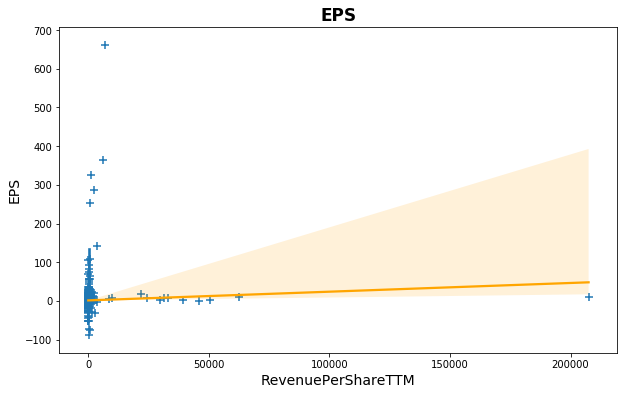

Correlation Coefficient:
 [[1.         0.04362026]
 [0.04362026 1.        ]]


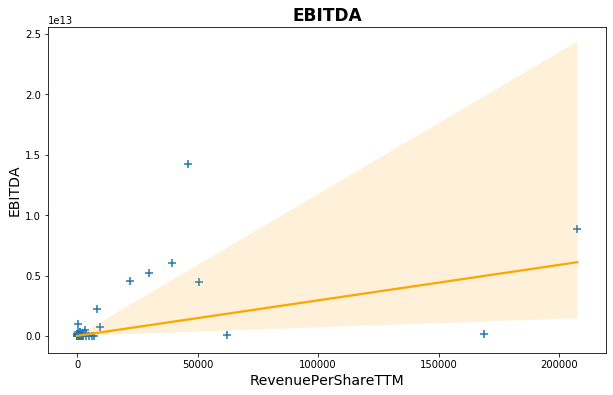

Correlation Coefficient:
 [[1.        0.4960739]
 [0.4960739 1.       ]]


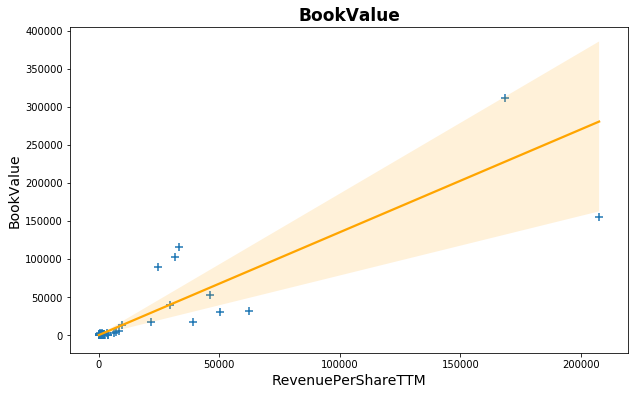

Correlation Coefficient:
 [[1.        0.9027279]
 [0.9027279 1.       ]]


In [799]:
## Cleaning base_data ##

## Drop all null values by Symbol
base_df.dropna(subset = ['Symbol'], inplace=True)


## Replace all 'None' with Null
for i in ['PERatio', 'PEGRatio', 'BookValue', 'DividendYield', 'EPS', 
          'MarketCapitalization', 'EBITDA', 'Beta', 'AnalystTargetPrice']:
    base_df[i] = base_df[i].replace('None', np.NaN)
    

## FillNa Dividiend Yield with 0
base_df['DividendYield'].fillna(0, inplace=True)
    

## Change to columns to float or int
for i in ['PERatio', 'PEGRatio', 'BookValue', 'DividendYield', 'EPS', 
          'MarketCapitalization', 'EBITDA', 'Beta', 'AnalystTargetPrice']:
    base_df[i] = base_df[i].map(lambda x: float(x))
    
    
## Drop Unnamed: 0
base_df.drop(['Unnamed: 0', 'Information', 'Error Message'], axis = 1, inplace=True)


## Change index name so it's easier to save and re-load
base_df.index.names = ['Index']


## Bin Market Cap
bins = [0, 300000000, 2000000000, 10000000000, 9999999999999]
labels = ['Micro-Cap', 'Small-Cap', 'Mid-Cap', 'Big-Cap']

base_df['Market-Cap'] = pd.cut(base_df['MarketCapitalization'], bins=bins, labels=labels)


## Add columns split_ever and split_last_5_yrs
base_df['split_ever'] = base_df['LastSplitDate'].map(lambda x: 0 if (x == 'None') else 1)

split_last_5_yrs = []
for i in base_df['LastSplitDate']:
    try:
        if int(i[:4]) > 2016:
            split_last_5_yrs.append(1)
        else:
            split_last_5_yrs.append(0)
    except:
        split_last_5_yrs.append(0)
base_df['split_last_5_yrs'] = split_last_5_yrs


## Add columns dividend_ever and dividend_last_3_yrs
base_df['dividend_ever'] = base_df['DividendDate'].map(lambda x: 0 if (x == 'None') else 1)

dividend_last_3_yrs = []
for i in base_df['DividendDate']:
    try:
        if int(i[:4]) > 2018:
            dividend_last_3_yrs.append(1)
        else:
            dividend_last_3_yrs.append(0)
    except:
        dividend_last_3_yrs.append(0)
base_df['dividend_3_yrs'] = dividend_last_3_yrs


## Fill EPS Null values
# Create new df with only EPS not null values 
EPS = base_df[base_df['EPS'].notna()]

# Drop Berkshire Hathway and LILM because of the significant outliers
EPS = EPS[EPS['EPS'] != 68287.15]
EPS = EPS[EPS['Symbol'] != 'LILM']

# Get rid of columns
EPS.drop(['PERatio', 'Beta', 'Market-Cap', 'DividendPerShare', 'DividendYield', 'PEGRatio',
          'EBITDA', 'AnalystTargetPrice'], axis=1, inplace = True)

# Remove object strings
EPS.drop(['Symbol', 'Name', 'Description', 'Country', 'Sector'], axis = 1, inplace=True)

# Remove remaining null rows (only about a hundred)
EPS.dropna(inplace=True)

# Pearson_Corr_matrix(EPS)

EPS_coeff = print_regplot(EPS, 'RevenuePerShareTTM', 'EPS')

EPS_to_add = []
for n,i in enumerate(base_df['EPS']):
    if np.isnan(i):
        EPS_to_add.append(base_df['RevenuePerShareTTM'].iloc[n] * EPS_coeff)
    else: 
        EPS_to_add.append(i)

base_df['EPS'] = EPS_to_add


## Fill beta missing values
Beta = base_df[base_df['Beta'].notna()]

for i in ['EBITDA', 'PERatio', 'PEGRatio', 'BookValue', 'DividendYield']:
    Beta[i] = Beta[i].fillna(Beta[i].mean())
    
Beta.drop(['Symbol', 'Name', 'Description', 'Country', 'Sector', 
           'Market-Cap', 'AnalystTargetPrice'], axis = 1, inplace=True)

# No promising multicollinearity, will resort to filling with normally distributed data
# Pearson_Corr_matrix(Beta)

# Fillna w/normally distributed features
index = base_df[base_df.Beta.isna()].index
value = np.random.normal(loc=base_df.Beta.mean(), scale=base_df.Beta.std(), size=base_df.Beta.isna().sum())

base_df.Beta.fillna(pd.Series(value, index=index), inplace=True)


## Fill EBITDA Missing Values
EBITDA = base_df[base_df['EBITDA'].notna()]

for i in ['PERatio', 'PEGRatio', 'BookValue', 'DividendYield']:
    EBITDA[i] = EBITDA[i].fillna(EBITDA[i].mean())
    
EBITDA.drop(['Symbol', 'Name', 'Description', 'Country', 'Sector', 
           'Market-Cap', 'AnalystTargetPrice'], axis = 1, inplace=True)

# Multicollinearity shows v high correlation with RevenuePerShareTT
EBITDA_coeff = print_regplot(EBITDA, 'RevenuePerShareTTM', 'EBITDA')

EBITDA_to_add = []
for n,i in enumerate(base_df['EBITDA']):
    if np.isnan(i):
        EBITDA_to_add.append(base_df['RevenuePerShareTTM'].iloc[n] * EBITDA_coeff)
    else: 
        EBITDA_to_add.append(i)

base_df['EBITDA'] = EBITDA_to_add


## Remove  Market Capitalization null values 
base_df = base_df[base_df['MarketCapitalization'].notna()]


## Fill PERatio
# Use the mean for market-cap and sector and apply to each null P/E ratio
grouped_PER = base_df[['PERatio','Market-Cap', 'Sector']].groupby(by=['Market-Cap', 'Sector'], as_index=False).mean()

PER = []
for n,i in enumerate(base_df['PERatio']):
    if np.isnan(i):
        PER.append(grouped_PER['PERatio'][(grouped_PER['Market-Cap']== base_df['Market-Cap'].iloc[n]) & 
                                          (grouped_PER['Sector']== base_df['Sector'].iloc[n])].item())
    else:
        PER.append(i)
        
base_df['PERatio'] = PER


## Fill PEGRatio
# Same Principle as PERatio
grouped_PEG = base_df[['PEGRatio','Market-Cap', 'Sector']].groupby(by=['Market-Cap', 'Sector'], as_index=False).mean()

PEG = []
for n,i in enumerate(base_df['PEGRatio']):
    if np.isnan(i):
        PEG.append(grouped_PEG['PEGRatio'][(grouped_PEG['Market-Cap']== base_df['Market-Cap'].iloc[n]) & 
                                          (grouped_PEG['Sector']== base_df['Sector'].iloc[n])].item())
    else:
        PEG.append(i)
        
base_df['PEGRatio'] = PEG


## ShortInterest Month on Month
base_df.reset_index(drop = True, inplace=True)
base_df['ShortInterestMonthDelta'] = (base_df['SharesShort']- base_df['SharesShortPriorMonth'])/base_df['SharesShortPriorMonth']
shortinterestinf = [i for i in base_df['ShortInterestMonthDelta'][base_df['ShortInterestMonthDelta']> 1000000].index]
mean_shortint = base_df['ShortInterestMonthDelta'][base_df['ShortInterestMonthDelta'] < 1000000].mean()
base_df['ShortInterestMonthDelta'].iloc[shortinterestinf] = mean_shortint
base_df['ShortInterestMonthDelta'].fillna(0, inplace=True)
base_df.drop(['SharesShort', 'SharesShortPriorMonth'], axis=1, inplace=True)


## Drop Unecessary Columns
base_df.drop(['AssetType', 'Currency', 'Address', 'CIK', 'FiscalYearEnd', 'LatestQuarter', 
              'Industry', 'Exchange', 'LastSplitDate', 'LastSplitFactor', 'ExDividendDate',
              'DividendDate', 'ForwardAnnualDividendRate', 'ForwardAnnualDividendYield',
              'DividendPerShare', 'TrailingPE', 'ForwardPE'], axis=1, inplace = True)

## Fill Null Book Values using multicollinearity plus regplot method
BookVal = base_df[base_df['BookValue'].notna()]

for i in ['AnalystTargetPrice']:
    BookVal[i] = BookVal[i].fillna(BookVal[i].mean())
    
BookVal.drop(['Symbol', 'Name', 'Description', 'Country', 'Sector', 
           'Market-Cap', ], axis = 1, inplace=True)

BookVal_coeff = print_regplot(BookVal, 'RevenuePerShareTTM', 'BookValue')

BookVal_to_add = []
for n,i in enumerate(base_df['BookValue']):
    if np.isnan(i):
        BookVal_to_add.append(base_df['RevenuePerShareTTM'].iloc[n] * BookVal_coeff)
    else: 
        BookVal_to_add.append(i)

base_df['BookValue'] = BookVal_to_add


## Turn Analyst Target to percentage vs 50daymovingavg
base_df['AnalystPercentTarget']=(base_df['AnalystTargetPrice']-base_df['50DayMovingAverage'])/base_df['50DayMovingAverage']
base_df['AnalystPercentTarget'].fillna(0, inplace=True)
base_df['AnalystPercentTarget'].iloc[base_df['AnalystPercentTarget'][base_df['AnalystPercentTarget']> 1000000].index.item()] = 0
base_df.drop(['AnalystTargetPrice', '50DayMovingAverage', '200DayMovingAverage'], axis=1, inplace=True)


## Add Percent Float
# Fix wrong ones with mean of non-wrong
base_df.reset_index(drop = True, inplace=True)
base_df['PercentFloat'] = base_df['SharesFloat']/base_df['SharesOutstanding']
percfloatwrong = [i for i in base_df[base_df['PercentFloat'] > 1].index]

mean_perc_float = base_df['PercentFloat'][base_df['PercentFloat'] <=1].mean()
base_df['PercentFloat'].iloc[[percfloatwrong]] = mean_perc_float
base_df['PercentFloat'].fillna(mean_perc_float, inplace=True)

base_df.drop(['SharesFloat', 'SharesOutstanding'], axis=1, inplace=True)


## Reset Index to not skip rows that we did not pull data for 
base_df.reset_index(drop = True, inplace=True)


base_df.to_csv('data/clean_df.csv')

In [801]:
base_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5253 entries, 0 to 5252
Data columns (total 43 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Symbol                      5253 non-null   object  
 1   Name                        5253 non-null   object  
 2   Description                 5253 non-null   object  
 3   Country                     5253 non-null   object  
 4   Sector                      5253 non-null   object  
 5   MarketCapitalization        5253 non-null   float64 
 6   EBITDA                      5253 non-null   float64 
 7   PERatio                     5253 non-null   float64 
 8   PEGRatio                    5253 non-null   float64 
 9   BookValue                   5253 non-null   float64 
 10  DividendYield               5253 non-null   float64 
 11  EPS                         5253 non-null   float64 
 12  RevenuePerShareTTM          5253 non-null   float64 
 13  ProfitMargin      

In [856]:
base_df.describe()

,MarketCapitalization,EBITDA,PERatio,PEGRatio,BookValue,DividendYield,EPS,RevenuePerShareTTM,ProfitMargin,OperatingMarginTTM,ReturnOnAssetsTTM,ReturnOnEquityTTM,RevenueTTM,GrossProfitTTM,DilutedEPSTTM,QuarterlyEarningsGrowthYOY,QuarterlyRevenueGrowthYOY,PriceToSalesRatioTTM,PriceToBookRatio,EVToRevenue,EVToEBITDA,Beta,52WeekHigh,52WeekLow,ShortRatio,ShortPercentOutstanding,ShortPercentFloat,PercentInsiders,PercentInstitutions,PayoutRatio,split_ever,split_last_5_yrs,dividend_ever,dividend_3_yrs,ShortInterestMonthDelta,AnalystPercentTarget,PercentFloat
count,5.253000e+03,5.253000e+03,5253.000000,5253.000000,5253.000000,5253.000000,5253.000000,5253.000000,5253.000000,5253.000000,5253.000000,5253.000000,5.253000e+03,5.253000e+03,5253.000000,5253.000000,5253.000000,5253.000000,5253.000000,5253.000000,5253.000000,5253.000000,5253.000000,5253.000000,5253.000000,5253.000000,5253.000000,5253.000000,5253.000000,5253.000000,5253.000000,5253.000000,5253.000000,5253.000000,5253.000000,5253.000000,5253.000000
mean,1.033850e+10,1.051712e+10,91.997660,4.168961,272.407577,0.023401,25.897844,210.611034,0.030515,-230.684091,-0.043851,-13305.478625,6.337390e+10,4.234795e+10,25.887181,200.754425,5.327846,800.345937,101.292728,762.743503,37.689085,1.635436,140.566151,86.005394,4.229536,0.026067,0.071620,11.657150,107.389877,0.104747,0.388730,0.110223,0.460118,0.399772,5.934502,3.173706,0.722354
std,6.696259e+10,2.728279e+11,276.474122,80.771676,6982.852320,0.568675,1333.402176,4668.164959,2.012997,11954.960955,0.515104,33968.472522,1.440993e+12,1.228182e+12,1333.402341,13801.017341,282.910680,24371.170263,6463.706638,24259.941519,428.620914,22.581180,6140.978074,4109.898788,5.389530,0.036506,1.232273,18.022086,4002.797803,0.392396,0.487508,0.313197,0.498454,0.489898,261.577843,157.521036,0.267958
min,1.000000e+03,-7.641000e+09,0.004100,-3426.670000,-128.110000,0.000000,-3206.130000,-1.998000,-2.994000,-692588.060000,-31.190000,-99999.990000,-9.478000e+06,-1.231700e+10,-3206.130000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-62.568571,0.120000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000
25%,2.334040e+08,0.000000e+00,19.500000,0.000000,0.761000,0.000000,-0.597000,0.046000,0.000000,-0.027100,-0.027100,-0.585000,1.517000e+06,0.000000e+00,-0.595000,0.000000,0.000000,0.181000,0.668000,0.000000,0.000000,0.584000,10.260000,4.050000,0.880000,0.000000,0.003500,0.302000,17.840000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.091080,0.000000,0.605620
50%,7.187030e+08,6.922200e+05,39.290000,1.280000,5.480000,0.000000,0.000000,4.739000,0.000000,0.008000,0.000100,0.000000,1.774180e+08,6.719900e+07,0.000000,0.000000,0.155000,1.874000,1.799000,1.336000,0.109000,1.186000,22.320000,9.800000,3.010000,0.010000,0.019000,3.019000,55.160000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.158658,0.770116
75%,3.789314e+09,1.964350e+08,82.132208,3.210021,17.710000,0.011000,1.751000,20.610000,0.111000,0.165000,0.039600,0.122000,1.458753e+09,5.393000e+08,1.739000,0.397000,0.485000,5.800000,4.104000,5.400000,14.300000,1.975000,53.970000,25.080000,5.590000,0.030000,0.049000,15.210000,84.310000,0.083600,1.000000,0.000000,1.000000,1.000000,0.132731,0.449533,0.947932
max,2.380597e+12,1.420572e+13,10130.000000,3262.790000,311184.380000,39.960000,68287.150000,207493.100000,115.210000,101465.040000,2.940000,4081.010000,6.388662e+13,8.207300e+13,68287.150000,1000000.000000,20469.480000,1000000.000000,468228.320000,1000000.000000,15623.260000,1237.080000,445000.000000,297820.000000,139.980000,0.360000,56.640000,98.210000,290153.540000,24.080000,1.000000,1.000000,1.000000,1.000000,18089.000000,11299.000000,1.000000


# EPS Work 

Current formula messes up dates in the index. I tried to use [26:] as a dirty fix but it ended up leaving duplicates for more recent years

For the time being, focus on setting up a clustering model before pulling additional data

In [ ]:
# Set empty dataframe and list
primary = pd.DataFrame([pd.to_datetime(-i, format='%Y').year for i in range(-2021,-1995)], columns=['Year'])
primary.set_index('Year', inplace=True)

no_EPS_data = []

In [ ]:
## Download Earnings Per Share Data for every stock
%%time
counter = 0
for i in clean_df.Symbol:
    url = f'https://www.alphavantage.co/query?function=EARNINGS&symbol={i}&apikey={key_alpha}'
    r = requests.get(url)
    data = r.json()
    
    counter += 1
    if counter%250 == 0:
        print(f"{counter} completed")

    if data['annualEarnings'] == []:
        no_EPS_data.append(i)

    else:
        test = pd.DataFrame(data['annualEarnings'])

        test.columns = ['fiscalDateEnding', i]

        test['Year'] = pd.to_datetime(test['fiscalDateEnding'], format= '%Y-%m-%d').dt.year

        test.drop(['fiscalDateEnding'], axis=1, inplace=True)

        test.set_index('Year', inplace=True)

        primary = primary.merge(test, how='left', left_on='Year', right_on='Year')[-26:]

In [ ]:
# primary.to_csv('data/EPS_data.csv')

# Cash Flow Data

In [495]:
url = 'https://www.alphavantage.co/query?function=CASH_FLOW&symbol=IBM&apikey='+ key_alpha
r = requests.get(url)
cash_flow_IBM = r.json()

NameError: name 'key_alpha' is not defined

## Archive

In [ ]:
# if stock split is greater than a certain ratio.
# Dropped because I don't see it being important
factor = []
for i in base_df['LastSplitFactor']:
    if i == 'None':
        factor.append(0)
    else:
        temp = i.split(':')
        if int(temp[1]) == 0:
            factor.append(0)
        else:
            if int(temp[0])/int(temp[1]) > 4:
                factor.append(1)